In [14]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit


In [26]:
seed = 42
random.seed(seed)
np.random.seed(seed)


In [27]:
# preprocess our feature and target
def preprocess_and_feature(data):
    df = data.copy()
    
    print("handle missing values...")
    df = df.dropna() 

    # our target y is 'close'
    features = [col for col in data.columns if col != 'date' and col !='Year_Month' and col !='close']

    scaler_features = StandardScaler()
    scaler_close = StandardScaler()
    
    data_scaled = pd.DataFrame(
        scaler_features.fit_transform(df[features]), 
        columns=features
    )
    data_scaled['close'] = scaler_close.fit_transform(df[['close']])

    # return scaler_close in order to restore 'close'
    return data_scaled, features, scaler_close


# split X and y with seq_length
def prepare_sequences(data_scaled, features, seq_length):
    X, y = [], []
    
    for i in range(len(data_scaled) - seq_length - 1):
        sequence = data_scaled[features].iloc[i:(i + seq_length)].values
        
        X.append(sequence)
        y.append(data_scaled['close'].iloc[i + seq_length + 1])

    X = np.array(X)
    y = np.array(y)
    
    print(f"X shape before reshape: {X.shape}")
    X = X.reshape(X.shape[0], -1)
    print(f"X shape after reshape: {X.shape}")
    
    return X, y

In [28]:
class ReturnPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_rate):
        super(ReturnPredictor, self).__init__()

        # define layers of our model
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LeakyReLU(0.1),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
            
        layers.append(nn.Linear(prev_dim, 1))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)


def train_model_with_config(X_train, y_train, X_val, y_val, config):
    model = ReturnPredictor(
        input_dim=X_train.shape[1],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate']
    )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.MSELoss()

    # regularization
    def compute_loss(outputs, targets, model, l1_lambda=config.get('l1_lambda', 0)):
        mse_loss = criterion(outputs.squeeze(), targets)
        
        l1_reg = torch.tensor(0., requires_grad=True)
        for param in model.parameters():
            l1_reg = l1_reg + torch.norm(param, 1)
        
        return mse_loss + l1_lambda * l1_reg
        
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(config['epochs']):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train)
        train_loss = compute_loss(outputs, y_train, model)
        train_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = compute_loss(val_outputs, y_val, model)
            
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        # find best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
        
    # load the best model        
    model.load_state_dict(best_model_state)
    return model, best_val_loss, train_losses, val_losses


def bias_variance_analysis(data_scaled, features, scaler_close, base_config):
    X, y = prepare_sequences(data_scaled, features, base_config['seq_length'])
    
    tscv = TimeSeriesSplit(n_splits=5)  # Time series cross validation
    y_pre = []  # Store predictions for each fold
    y_true = []
    
    print("Bias-Variance Analysis")
    # split it into different fold and do not change its order due to timeseries data
    for train_idx, val_idx in tscv.split(X):
       # Split data into train and validation sets
       X_train = torch.FloatTensor(X[train_idx])
       X_val = torch.FloatTensor(X[val_idx])
       y_train = torch.FloatTensor(y[train_idx])
       y_val = torch.FloatTensor(y[val_idx])
       
       model, _, _, _ = train_model_with_config(
                X_train, y_train,
                X_val, y_val,
                base_config
            )
       
       model.eval()
       with torch.no_grad():
            val_pred = model(X_val).numpy().squeeze() 

            # restore y
            val_pred = scaler_close.inverse_transform(val_pred.reshape(-1, 1)).squeeze()
            y_val_true = scaler_close.inverse_transform(y_val.numpy().reshape(-1, 1)).squeeze()
            
            y_pre.append(val_pred)
            y_true.append(y_val_true)    
    
    y_pre = np.array(y_pre)
    y_true = np.array(y_true)
    
    # get mean of all fold
    mean_pred = np.mean(y_pre, axis=0)
    mean_true = np.mean(y_true, axis=0) 
    
    bias = np.mean((mean_pred - mean_true) ** 2)
    variance = np.var(y_pre, axis=0).mean()
    
    # Visualizations
    plt.figure(figsize=(15, 5))
    for i in range(len(y_pre)):
       plt.plot(y_pre[i][:100], alpha=0.3, label=f'Fold {i+1}')
    plt.title('Predictions Across Folds')
    plt.legend()
    plt.show()

    # Model calibration (bias-variance analysis)
    print("\nBias-Variance Analysis Results:")
    print(f"Average Bias: {bias:.6f}")
    print(f"Average Variance: {variance:.6f}")
    print(f"Total Error（Bias + Variance）: {bias + variance:.6f}")

    if bias > variance:
       print("\nModel shows high bias (underfitting). Recommendations:")
       print("1. Increase model complexity")
       print("2. Reduce regularization")
       print("3. Add more features")
    elif variance > bias:
       print("\nModel shows high variance (overfitting). Recommendations:")
       print("1. Increase regularization")
       print("2. Reduce model complexity")
       print("3. Add more training data")
    else:
       print("\nModel shows good bias-variance trade-off")
   
    return bias, variance


def conduct_ablation_study(data_scaled, features, scaler_close, base_config):
    # impact of 15 different configurations.
    configurations = {
        'base_model': base_config,
        'minimal_network': {**base_config, 'hidden_dims': [32]},
        'shallow_network': {**base_config, 'hidden_dims': [64, 32]},
        'wide_network': {**base_config, 'hidden_dims': [512, 256, 128]},
        'deeper_network': {**base_config, 'hidden_dims': [256, 128, 64, 32]},
        'very_deep_network': {**base_config, 'hidden_dims': [256, 128, 64, 32, 16]},
        
        'high_dropout': {**base_config, 'dropout_rate': 0.5},
        'no_dropout': {**base_config, 'dropout_rate': 0.0},
        
        'high_lr': {**base_config, 'lr': 0.01},
        'low_lr': {**base_config, 'lr': 0.0001},
        
        'long_sequence': {**base_config, 'seq_length': 10},
        'short_sequence': {**base_config, 'seq_length': 3},

        'high_l1': {**base_config, 'l1_lambda': 0.1},
        'medium_l1': {**base_config, 'l1_lambda': 0.01},
        'low_l1': {**base_config, 'l1_lambda': 0.001}
        
    }

    
    results = {}
    tscv = TimeSeriesSplit(n_splits=5)
    
    for name, config in configurations.items():
        print(f"\nTesting configuration: {name}")
        fold_scores = []
        fold_errors = []

        all_train_losses = []
        all_val_losses = []

        # To get different seq_length
        X, y = prepare_sequences(data_scaled, features, config['seq_length'])
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train_fold = torch.FloatTensor(X[train_idx])
            y_train_fold = torch.FloatTensor(y[train_idx])
            X_val_fold = torch.FloatTensor(X[val_idx])
            y_val_fold = torch.FloatTensor(y[val_idx])
            
            model, val_loss, train_losses, val_losses = train_model_with_config(
                X_train_fold, y_train_fold,
                X_val_fold, y_val_fold,
                config
            )
            
            model.eval()
            with torch.no_grad():
                val_pred = model(X_val_fold).numpy().squeeze()


            val_pred = scaler_close.inverse_transform(val_pred.reshape(-1, 1)).squeeze()
            y_val_true = scaler_close.inverse_transform(y_val_fold.numpy().reshape(-1, 1)).squeeze()

            # evaluate model with r2
            fold_score = r2_score(y_val_true, val_pred)
            fold_scores.append(fold_score)
            
            errors = np.abs(val_pred - y_val_true)
            fold_errors.extend(errors)
            
            all_train_losses.append(train_losses)
            all_val_losses.append(val_losses)

        # record result
        results[name] = {
            'mean_r2': np.mean(fold_scores),
            'std_r2': np.std(fold_scores),
            'errors': fold_errors,
            'train_losses': np.mean(all_train_losses, axis=0),
            'val_losses': np.mean(all_val_losses, axis=0),
            'config':config
        }
        
        print(f"Configuration {name}:")
        print(f"Mean R2: {results[name]['mean_r2']:.4f} (±{results[name]['std_r2']:.4f})")
    
    return results


# extreme errors analysis
def analyze_extreme_errors(results, predictions, actuals):
    errors = np.abs(predictions - actuals)
    extreme_errors_idx = errors > np.percentile(errors, 95)
    
    print("\nExtreme Error Analysis:")
    print(f"Number of extreme errors 95 percentile: {sum(extreme_errors_idx)}")
    print(f"Mean error: {errors.mean():.6f}")
    print(f"Std error: {errors.std():.6f}")
    print(f"95th percentile error: {np.percentile(errors, 95):.6f}")
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(errors, bins=50)
    plt.title('Error Distribution (abs(predictions - actuals))')
    plt.xlabel('Absolute Error')
    plt.ylabel('Count')
    
    plt.subplot(1, 3, 2)
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.scatter(actuals[extreme_errors_idx], predictions[extreme_errors_idx], 
                color='red', label='Extreme Errors')
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 
             'k--', label='Perfect Prediction')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.hist(errors[extreme_errors_idx], bins=20)
    plt.title('Extreme Errors Distribution(over 95 percentile)')
    plt.xlabel('Absolute Error')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    return extreme_errors_idx

    

def predict_returns(data, seq_length=5):
    
    data_scaled, features, scaler_close = preprocess_and_feature(data)
    
    base_config = {
        'hidden_dims': [128, 64],
        'dropout_rate': 0.3,
        'lr': 0.001,
        'epochs': 50,
        'seq_length': seq_length,
        'l1_lambda': 0
    }

    # 1.Bias and variance analysis to get insight of our base_config model
    _, _ = bias_variance_analysis(data_scaled, features, scaler_close, base_config)

    
    # 2.Conduct ablation study.(at-least 10 different configurations)
    ablation_results = conduct_ablation_study(data_scaled, features, scaler_close, base_config)

    
    # 3.Find best configuration based on ablation results.
    best_config_name = max(ablation_results.keys(), 
                          key=lambda k: ablation_results[k]['mean_r2'])
    print(f"\nBest configuration: {best_config_name}")
    
    # This is our ablation config
    configurations = {
        'base_model': base_config,
        'minimal_network': {**base_config, 'hidden_dims': [32]},
        'shallow_network': {**base_config, 'hidden_dims': [64, 32]},
        'wide_network': {**base_config, 'hidden_dims': [512, 256, 128]},
        'deeper_network': {**base_config, 'hidden_dims': [256, 128, 64, 32]},
        'very_deep_network': {**base_config, 'hidden_dims': [256, 128, 64, 32, 16]},
        
        'high_dropout': {**base_config, 'dropout_rate': 0.5},
        'no_dropout': {**base_config, 'dropout_rate': 0.0},
        
        'high_lr': {**base_config, 'lr': 0.01},
        'low_lr': {**base_config, 'lr': 0.0001},
        
        'long_sequence': {**base_config, 'seq_length': 10},
        'short_sequence': {**base_config, 'seq_length': 3},

        'high_l1': {**base_config, 'l1_lambda': 0.1},
        'medium_l1': {**base_config, 'l1_lambda': 0.01},
        'low_l1': {**base_config, 'l1_lambda': 0.001}
        
    }

    best_config = configurations[best_config_name]
    

    # 4. Use parameters of bese model to train our whole data.Previous step based on k-fold data
    X, y = prepare_sequences(data_scaled, features, best_config['seq_length'])
    
    # Train final model with best configuration
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)
    
    # Use best configuration instead of base_config
    model, _, train_losses, val_losses = train_model_with_config(
        X_train, y_train, X_test, y_test, best_config  
    )
    
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).numpy()
    
    predictions = scaler_close.inverse_transform(predictions.reshape(-1, 1)).squeeze()
    actuals = scaler_close.inverse_transform(y_test.reshape(-1, 1).numpy()).squeeze()

    # 5.Insightful analysis of extreme-errors
    analyze_extreme_errors(ablation_results, predictions, actuals)
    
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    
    print('\nFinal Model Metrics (using best configuration):')
    print(f'Configuration: {best_config_name}')
    print(f'MSE: {mse:.6f}')
    print(f'MAE: {mae:.6f}')
    print(f'R2: {r2:.6f}')
    
    return predictions, actuals, train_losses, val_losses



In [29]:
data = pd.read_csv('SP500_2002_2022.csv')

handle missing values...
X shape before reshape: (5029, 5, 14)
X shape after reshape: (5029, 70)
Bias-Variance Analysis


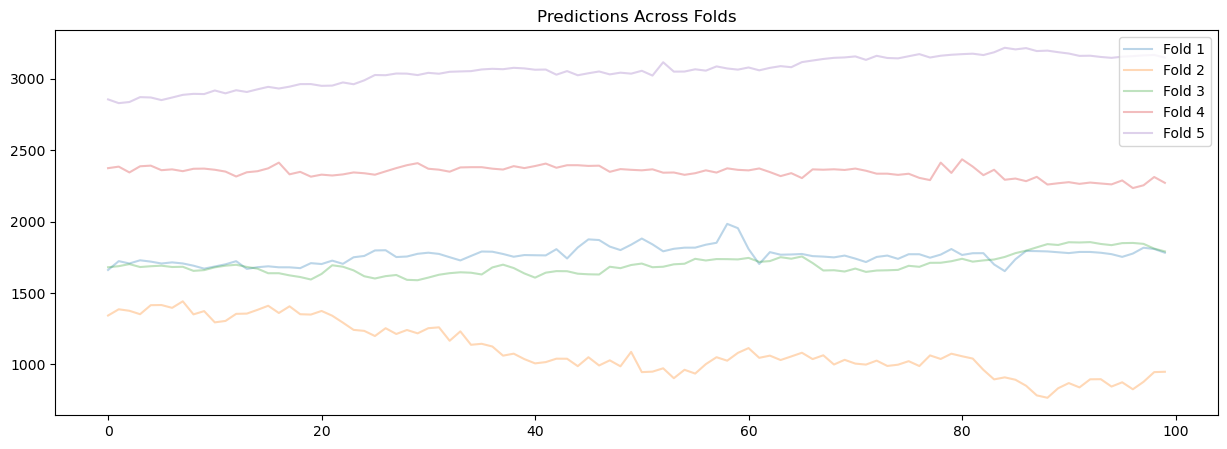


Bias-Variance Analysis Results:
Average Bias: 54643.414062
Average Variance: 849331.937500
Total Error（Bias + Variance）: 903975.375000

Model shows high variance (overfitting). Recommendations:
1. Increase regularization
2. Reduce model complexity
3. Add more training data

Testing configuration: base_model
X shape before reshape: (5029, 5, 14)
X shape after reshape: (5029, 70)
Configuration base_model:
Mean R2: -8.7402 (±15.0923)

Testing configuration: minimal_network
X shape before reshape: (5029, 5, 14)
X shape after reshape: (5029, 70)
Configuration minimal_network:
Mean R2: -6.8970 (±9.2279)

Testing configuration: shallow_network
X shape before reshape: (5029, 5, 14)
X shape after reshape: (5029, 70)
Configuration shallow_network:
Mean R2: -7.2284 (±9.8623)

Testing configuration: wide_network
X shape before reshape: (5029, 5, 14)
X shape after reshape: (5029, 70)
Configuration wide_network:
Mean R2: -1.6473 (±2.7550)

Testing configuration: deeper_network
X shape before reshap

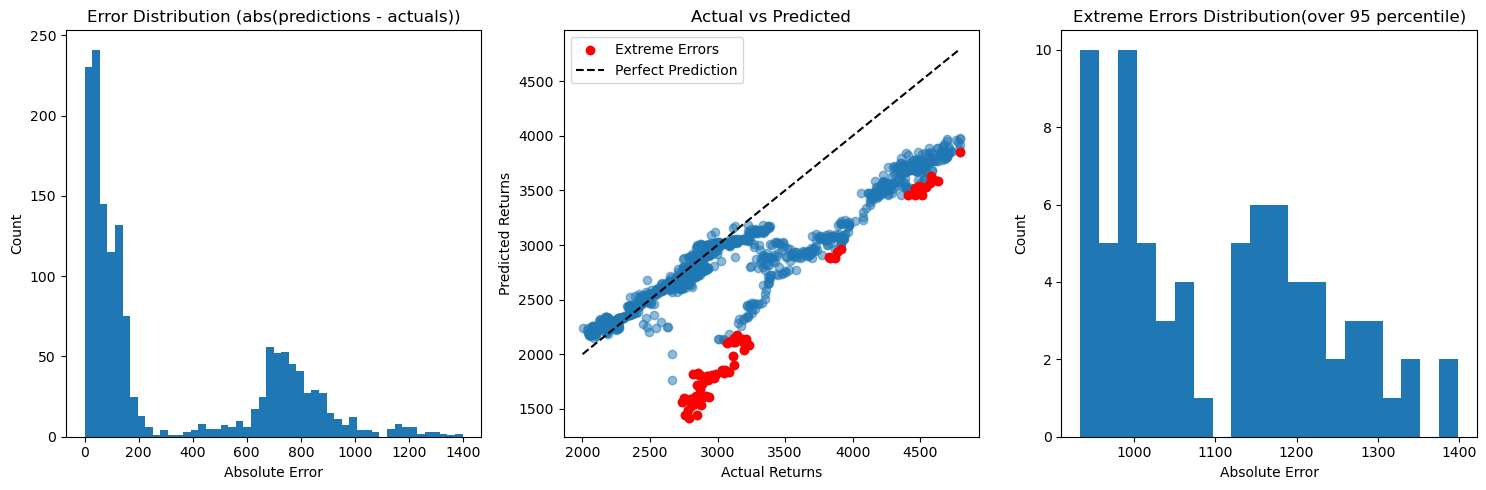


Final Model Metrics (using best configuration):
Configuration: high_lr
MSE: 228141.421875
MAE: 318.656219
R2: 0.598349


In [30]:

predictions, actual_values, train_losses, val_losses = predict_returns(data, seq_length=5)

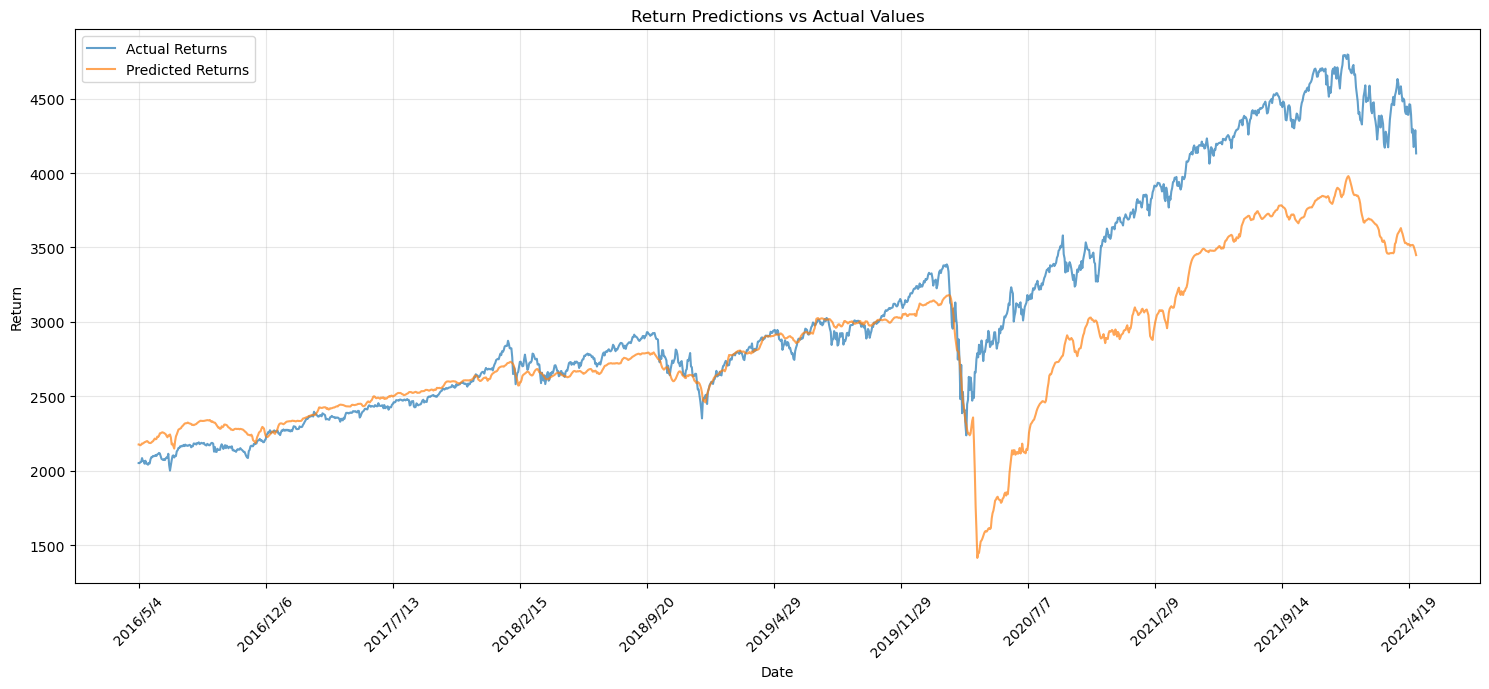

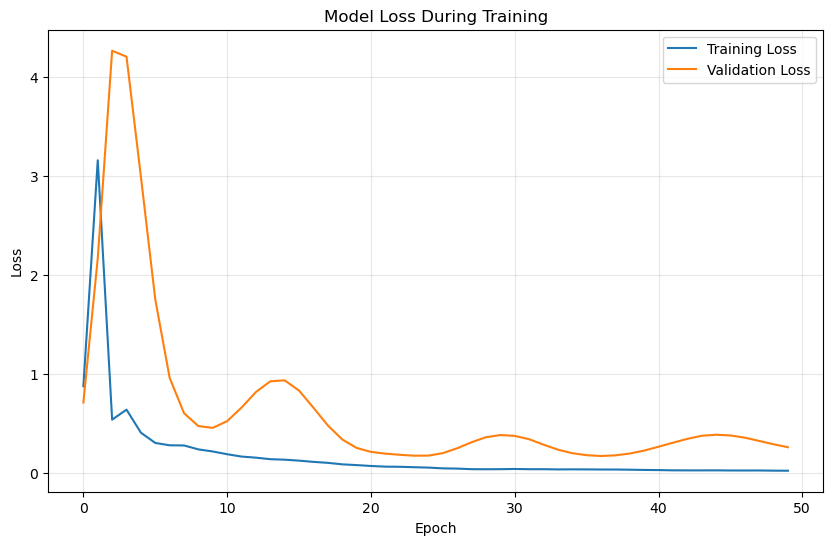

In [31]:
# Visualizations

test_dates = data.iloc[-(len(predictions)):]['date'].values
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(test_dates, actual_values, label='Actual Returns', alpha=0.7)
ax.plot(test_dates, predictions, label='Predicted Returns', alpha=0.7)

n_ticks = 10 
step = len(test_dates) // n_ticks
plt.xticks(test_dates[::step], test_dates[::step], rotation=45)

plt.title('Return Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Draw model loss duing training
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
